# Active Inference - Mountain car

This notebooks covers fundamentals of the Active Inference framework implemented with the Bethe Free Energy optimisation with message passing on factor graphs. We use the mountain car problem as a simple example:

In [1]:
import Pkg; Pkg.activate(".");

  Activating project at `~/.julia/dev/RxInfer.jl/examples`


In [2]:
using RxInfer, Plots

## The mountain and physics 

For the purpose of this example we create a simple mountain valley with hard-coded physics, such that we do not depend on any external complex library. We have several configurable parameters for the experiment:
- Engine-force limit
- Tires friction coefficient

In [3]:
import HypergeometricFunctions: _₂F₁

function create_physics(; engine_force_limit = 0.04, friction_coefficient = 0.1)
    
    # Engine force as function of action
    Fa = (a::Real) -> engine_force_limit * tanh(a) 
    # Derivative of the engine force
    Fa_prime = (a::Real) -> engine_force_limit - engine_force_limit * tanh(a)^2 
    # Friction force as function of velocity
    Ff = (y_dot::Real) -> -friction_coefficient * y_dot 
    # Derivative of the friction force
    Ff_prime = (y_dot::Real) -> -friction_coefficient 
    
    # Gravitational force (horizontal component) as function of position
    Fg = (y::Real) -> begin
        if y < 0
            0.05*(-2*y - 1)
        else
            0.05*(-(1 + 5*y^2)^(-0.5) - (y^2)*(1 + 5*y^2)^(-3/2) - (y^4)/16)
        end
    end

    # Derivative of the gravitational force
    Fg_prime = (y::Real) -> begin 
        if y < 0
            -0.1
        else
            0.05*((-4*y^3)/16 + (5*y)/(1 + 5*y^2)^1.5 + (3*5*y^3)/(1 + 5*y^2)^(5/2) - (2*y)/(1 + 5*y^2)^(3/2))
        end
    end
    
    height = (x::Float64) -> begin
        if x < 0
            h = x^2 + x
        else
            h = x * _₂F₁(0.5,0.5,1.5, -5*x^2) + x^3 * _₂F₁(1.5, 1.5, 2.5, -5*x^2) / 3 + x^5 / 80
        end
        return 0.05*h
    end
    
    return (Fa, Fa_prime, Ff, Ff_prime, Fg, Fg_prime, height)
end

create_physics (generic function with 1 method)

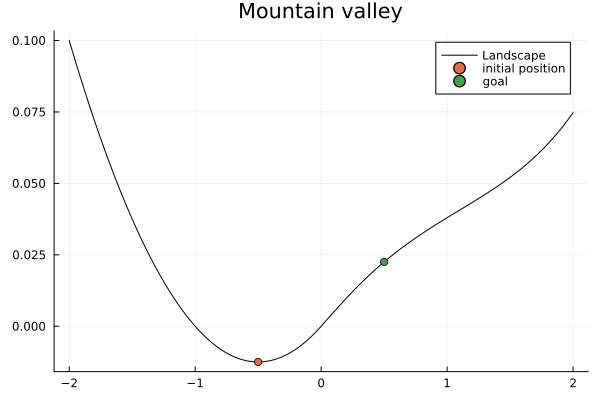

In [10]:
engine_force_limit   = 0.04
friction_coefficient = 0.1

Fa, Fa_prime, Ff, Ff_prime, Fg, Fg_prime, height = create_physics(
    engine_force_limit = engine_force_limit,
    friction_coefficient = friction_coefficient
);

initial_position = -0.5
initial_velocity = 0.0

x_target = [0.5, 0.0] 

valley_x = range(-2, 2, length=400)
valley_y = [ height(xs) for xs in valley_x ]
plot(valley_x, valley_y, title = "Mountain valley", label = "Landscape", color = "black")
scatter!([ initial_position ], [ height(initial_position) ], label="initial position")   
scatter!([x_target[1]], [height(x_target[1])], label="goal")   

# World - agent interaction

Because the states of the world are unknown to the agent, we wrap them in a comprehension. The comprehension returns only the functions for interacting with the world and not the hidden states. This way, we introduce a stateful world whose states cannot be directly observed.

In [5]:
function create_world(; Fg, Ff, Fa, initial_position = -0.5, initial_velocity = 0.0)

    y_t_min = initial_position
    y_dot_t_min = initial_velocity
    
    y_t = y_t_min
    y_dot_t = y_dot_t_min
    
    execute = (a_t::Float64) -> begin
        # Compute next state
        y_dot_t = y_dot_t_min + Fg(y_t_min) + Ff(y_dot_t_min) + Fa(a_t)
        y_t = y_t_min + y_dot_t
    
        # Reset state for next step
        y_t_min = y_t
        y_dot_t_min = y_dot_t
    end
    
    observe = () -> begin 
        return [y_t, y_dot_t]
    end
        
    return (execute, observe)
end

create_world (generic function with 1 method)

## Naive approach

In this simulation we are going to perform a naive action policy for tight full-power only. In this case, with limited engine power, the agent should not be able to achieve its goal:

┌ Info: Saved animation to /Users/bvdmitri/.julia/dev/RxInfer.jl/examples/tmp.gif
└ @ Plots /Users/bvdmitri/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/Users/bvdmitri/.julia/dev/RxInfer.jl/examples/tmp.gif")
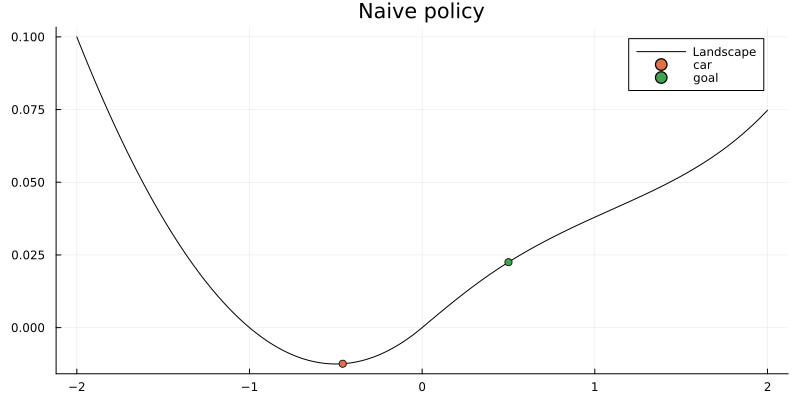

In [11]:
N_naive  = 100 # Total simulation time
pi_naive = 100.0 * ones(N_naive) # Naive policy for right full-power only

# Let there be a world
(execute_naive, observe_naive) = create_world(; 
    Fg = Fg, Ff = Ff, Fa = Fa, 
    initial_position = initial_position, 
    initial_velocity = initial_velocity
);

y_naive = Vector{Vector{Float64}}(undef, N_naive)
for t = 1:N_naive
    execute_naive(pi_naive[t]) # Execute environmental process
    y_naive[t] = observe_naive() # Observe external states
end

@gif for i in 1:N_naive
    plot(valley_x, valley_y, title = "Naive policy", label = "Landscape", color = "black", size = (800, 400))
    scatter!([y_naive[i][1]], [height(y_naive[i][1])], label="car")
    scatter!([x_target[1]], [height(x_target[1])], label="goal")   
end

# Active inference approach

In the active inference approach we are going to create an agent that models the environment around itself as well as the best possible actions in a probabilistic manner. That should help agent to understand that the brute-force approach is not the most efficient one and hopefully to realise that a little bit of swing is necessary to achieve its goal.

The code in the next block defines the agent's internal beliefs over the external dynamics and its probabilistic model of the environment, which correspond accurately by directly using the functions defined above. We use the `@model` macro from `RxInfer` to define the probabilistic model and the `meta` block to define approximation methods for the nonlinear state-transition functions.

In the model specification we in addition to the current state of the agent we include the beliefs over its future states (up to `T` steps ahead):

In [7]:
@model function mountain_car(; T, Fg, Fa, Ff, engine_force_limit)
    
    # Transition function modeling transition due to gravity and friction
    g = (s_t_min::AbstractVector) -> begin 
        s_t = similar(s_t_min) # Next state
        s_t[2] = s_t_min[2] + Fg(s_t_min[1]) + Ff(s_t_min[2]) # Update velocity
        s_t[1] = s_t_min[1] + s_t[2] # Update position
        return s_t
    end
    
    # Function for modeling engine control
    h = (u::AbstractVector) -> [0.0, Fa(u[1])] 
    
    # Inverse engine force, from change in state to corresponding engine force
    h_inv = (delta_s_dot::AbstractVector) -> [atanh(clamp(delta_s_dot[2], -engine_force_limit+1e-3, engine_force_limit-1e-3)/engine_force_limit)] 
    
    # Internal model perameters
    Gamma = 1e4*diageye(2) # Transition precision
    Theta = 1e-4*diageye(2) # Observation variance
    
    m_s_t_min = datavar(Vector{Float64})
    V_s_t_min = datavar(Matrix{Float64})

    s_t_min ~ MvNormal(mean = m_s_t_min, cov = V_s_t_min)
    s_k_min = s_t_min
    
    m_u = datavar(Vector{Float64}, T)
    V_u = datavar(Matrix{Float64}, T)
    
    m_x = datavar(Vector{Float64}, T)
    V_x = datavar(Matrix{Float64}, T)
    
    u = randomvar(T)
    s = randomvar(T)
    x = randomvar(T)
    
    u_h_k = randomvar(T)
    s_g_k = randomvar(T)
    u_s_sum = randomvar(T)
    
    for k in 1:T
        u[k] ~ MvNormal(mean = m_u[k], cov = V_u[k])
        u_h_k[k] ~ h(u[k]) where { meta = DeltaMeta(method = Linearization(), inverse = h_inv) }
        s_g_k[k] ~ g(s_k_min) where { meta = DeltaMeta(method = Linearization()) }
        u_s_sum[k] ~ s_g_k[k] + u_h_k[k]
        s[k] ~ MvNormal(mean = u_s_sum[k], precision = Gamma)
        x[k] ~ MvNormal(mean = s[k], cov = Theta)
        x[k] ~ MvNormal(mean = m_x[k], cov = V_x[k]) # goal
        s_k_min = s[k]
    end
    
    return (s, )
end

Because states of the agent are unknown to the world, we wrap them in a comprehension.
The comprehension only returns functions for interacting with the agent.
Internal beliefs cannot be directly observed, and interaction is only allowed through the Markov blanket

In [8]:
# We are going to use some private functionality from ReactiveMP, 
# in the future we should expose a proper API for this
import ReactiveMP: getrecent, messageout

function create_agent(; T = 20, Fg, Fa, Ff, engine_force_limit, x_target, initial_position, initial_velocity)
    Epsilon = fill(huge, 1, 1)                # Control prior variance
    m_u = Vector{Float64}[ [ 0.0] for k=1:T ] # Set control priors
    V_u = Matrix{Float64}[ Epsilon for k=1:T ]

    Sigma    = 1e-4*diageye(2) # Goal prior variance
    m_x      = [zeros(2) for k=1:T]
    V_x      = [huge*diageye(2) for k=1:T]
    V_x[end] = Sigma # Set prior to reach goal at t=T

    # Set initial brain state prior
    m_s_t_min = [initial_position, initial_velocity] 
    V_s_t_min = tiny * diageye(2)
    
    # Set current inference results
    result = nothing

    infer = (upsilon_t::Float64, y_hat_t::Vector{Float64}) -> begin
        m_u[1] = [ upsilon_t ] # Register action with the generative model
        V_u[1] = fill(tiny, 1, 1) # Clamp control prior to performed action

        m_x[1] = y_hat_t # Register observation with the generative model
        V_x[1] = tiny*diageye(2) # Clamp goal prior to observation

        data = Dict(:m_u       => m_u, 
                    :V_u       => V_u, 
                    :m_x       => m_x, 
                    :V_x       => V_x,
                    :m_s_t_min => m_s_t_min,
                    :V_s_t_min => V_s_t_min)
        
        model  = mountain_car(; T = T, Fg = Fg, Fa = Fa, Ff = Ff, engine_force_limit = engine_force_limit) 
        result = inference(model = model, data = data)
    end
    
    act = () -> begin
        if result !== nothing
            return mode(result.posteriors[:u][2])[1]
        else
            return 0.0
        end
    end
    
    future = () -> begin 
        if result !== nothing 
            return getindex.(mode.(result.posteriors[:s]), 1)
        else
            return zeros(T)
        end
    end

    slide = () -> begin
        (s, ) = result.returnval
        
        slide_msg_idx = 3 # This index is model dependend
        (m_s_t_min, V_s_t_min) = mean_cov(getrecent(messageout(s[2], slide_msg_idx)))

        m_u = circshift(m_u, -1)
        m_u[end] = [0.0]
        V_u = circshift(V_u, -1)
        V_u[end] = Epsilon

        m_x = circshift(m_x, -1)
        m_x[end] = x_target
        V_x = circshift(V_x, -1)
        V_x[end] = Sigma
    end

    return (infer, act, slide, future)    
end

create_agent (generic function with 1 method)

┌ Info: Saved animation to /Users/bvdmitri/.julia/dev/RxInfer.jl/examples/tmp.gif
└ @ Plots /Users/bvdmitri/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/Users/bvdmitri/.julia/dev/RxInfer.jl/examples/tmp.gif")
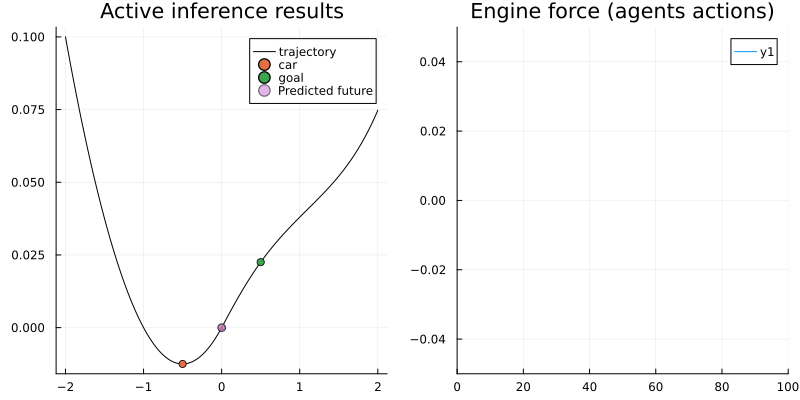

In [9]:
(execute_ai, observe_ai) = create_world(
    Fg = Fg, Ff = Ff, Fa = Fa, 
    initial_position = initial_position, 
    initial_velocity = initial_velocity
) # Let there be a world

T_ai = 50

(infer_ai, act_ai, slide_ai, future_ai) = create_agent(; # Let there be an agent
    T  = T_ai, 
    Fa = Fa,
    Fg = Fg, 
    Ff = Ff, 
    engine_force_limit = engine_force_limit,
    x_target = x_target,
    initial_position = initial_position,
    initial_velocity = initial_velocity
) 

N_ai = 100

# Step through experimental protocol
agent_a = Vector{Float64}(undef, N_ai) # Actions
agent_f = Vector{Vector{Float64}}(undef, N_ai) # Predicted future
agent_x = Vector{Vector{Float64}}(undef, N_ai) # Observations

for t=1:N_ai
    agent_a[t] = act_ai()            # Invoke an action from the agent
    agent_f[t] = future_ai()         # Fetch the predicted future states
    execute_ai(agent_a[t])           # The action influences hidden external states
    agent_x[t] = observe_ai()        # Observe the current environmental outcome (update p)
    infer_ai(agent_a[t], agent_x[t]) # Infer beliefs from current model state (update q)
    slide_ai()                       # Prepare for next iteration
end

@gif for i in 1:N_ai
    # pls - plot landscape
    pls = plot(valley_x, valley_y, title = "Active inference results", label = "Landscape", color = "black")
    pls = scatter!(pls, [agent_x[i][1]], [height(agent_x[i][1])], label="car")
    pls = scatter!(pls, [x_target[1]], [height(x_target[1])], label="goal")   
    pls = scatter!(pls, agent_f[i], height.(agent_f[i]), label = "Predicted future", alpha = map(i -> 0.5 / i, 1:T_ai))
    
    # pef - plot engine force
    pef = plot(Fa.(agent_a[1:i]), title = "Engine force (agents actions)", xlim = (0, N_ai), ylim = (-0.05, 0.05))
    
    plot(pls, pef, size = (800, 400))
end

As we can see the agent does indeed swing in order to reach its goal. Its interesting though that in the beginning the agent does not attempt to do that but only after some time has passed. That can be explained by the fact that we set `T_ai = 50`, which means that the agent must reach its goal after 50 time steps. In the beginning of the simulation this time horizon appears to be so far in the future that the agent decides not to do anything smart. After around `30` time steps the goal target becomes closer in time (agent has less than 20 time steps left to achieve the goal) and agent finally decides to act and realises that in order to achieve its goal it must swing and otherwise is not possible.